In [79]:
import os
import pandas as pd
from am4pa.linnea import LinneaConfig, MeasurementsLinnea
from algorithm_ranking import RankVariantsDFGTr, MeasurementsVisualizer
from pm4py.objects.conversion.log import converter as log_converter

In [2]:
from typing import List
from variants_compare import VariantsCompare

In [3]:
class OperandsManager:
    def __init__(self):
        self.df = pd.DataFrame(columns=['op', 'generated', 'measured'])
        
    def op_str(self, op:List):
        return "_".join(op)
        
    def add_operands(self, ops:List):
        for op in ops:
            op_str = self.op_str(op)
            if not op_str in self.df['op'].values:
                row = {'op':op_str, 'generated': False, 'measured':False}
                self.df = self.df.append(row, ignore_index=True)
                
    def set_generated(self, op:List):
        self.df.loc[self.df['op'] == self.op_str(op), 'generated'] = True
        
    def is_generated(self, op:List):
        return self.df.loc[self.df['op'] == self.op_str(op), 'generated'].values[0]
    
    def set_measured(self, op:List):
        self.df.loc[self.df['op'] == self.op_str(op), 'measured'] = True
        
    def is_measured(self, op:List):
        return self.df.loc[self.df['op'] == self.op_str(op), 'measured'].values[0]
        
        
        
        

In [4]:
om = OperandsManager()

In [5]:
om.df

,op,generated,measured


In [6]:
op_sizes = [["1000", "200"], ["1000", "300"], ["1000", "100"], ["1000", "150"], ["1000", "450"] ]

In [7]:
om.add_operands(op_sizes)

In [8]:
om.df

,op,generated,measured
0,1000_200,False,False
1,1000_300,False,False
2,1000_100,False,False
3,1000_150,False,False
4,1000_450,False,False


In [9]:
om.set_generated(op_sizes[1])

In [10]:
om.df

,op,generated,measured
0,1000_200,False,False
1,1000_300,True,False
2,1000_100,False,False
3,1000_150,False,False
4,1000_450,False,False


In [11]:
om.is_generated(op_sizes[0])

False

In [102]:
class DataExtractorLinnea:
    def __init__(self, linnea_config:LinneaConfig):
        self.lc = linnea_config
        self.om = OperandsManager() 
        self.mls = {}
        self.backend = linnea_config.backend
        self.run_ids = set()
        self.Ranker = RankVariantsDFGTr
        self.bRankReliable = True
        self.q_max = 75
        self.q_min = 25
        
        self.data_vcs = {}
        self.data_kernels = None
        self.data_relations = None
        self.data_best_kseq = None
        self.data_worst_kseq = None
        self.data_ext = None
        self.data_ranks = {}
        
    def add_operands(self, ops:List, bSync=True):
        self.om.add_operands(ops)
        for op in ops:
            self.mls[self.om.op_str(op)] = MeasurementsLinnea(self.lc, op)
            if bSync:
                self._sync_data(self.mls[self.om.op_str(op)])
    
    def _sync_data(self, ml):
        if self.backend:
            if self.lc.bm.check_if_dir_exists(ml.runner.operands_dir):
                self.om.set_generated(ml.op_sizes)
                ret = ml.data_collector.get_runtimes_table()
                if isinstance(ret, pd.DataFrame):
                    ml.measured_once = True
        else:
            #TODO
            pass
        
    def generate_variants(self):
        for k,v in self.mls.items():
            if not self.om.is_generated(k.split("_")):
                print("Generating Variants for {}".format(k))
                v.generate_variants()
                self.om.set_generated(k.split("_"))
                
    def gather_all_variants(self):
        for k,v in self.mls.items():
            v.gather_all_variants()
            
    def filter_on_flops(self, rel_flops=1.2):
        for k,v in self.mls.items():
            v.filter_on_flops(rel_flops=rel_flops)
            
    def filter_on_rel_duration(self, rel_d=1.2):
        for k,v in self.mls.items():
            if not v.measured_once:
                v.measure_once()
            v.filter_on_flops_rel_duration(rel_duration=rel_d)
            
            
    def check_measured(self, run_id):
        for k,v in self.mls.items():
            df = v.data_collector.get_runtimes_competing_table(run_id)
            if isinstance(df, pd.DataFrame):
                self.om.set_measured(k.split("_"))    
                self.run_ids.add(run_id)
                
    def measure_variants(self, reps=5, run_id=0):
        if not run_id in self.run_ids:
            self.reset_measured()
            self.run_ids.add(run_id)
        
        for k,v in self.mls.items():
            if not self.om.is_measured(k.split("_")): 
                print("Measuring Variants for {}".format(k))
                v.measure(reps, run_id)
                self.om.set_measured(k.split("_")) 
                
    def reset_measured(self):
        self.om.df['measured'] = False
        
        
    def _clean_concept(self, name):
        splits = name.split('=')
        if len(splits) > 1:
            return splits[-1].strip()
        return splits[0].strip()

    def _rank_variants(self, alg_measurements, alg_list):
        rv = self.Ranker(alg_measurements, alg_list)
        return rv.rank_variants(q_max = self.q_max, q_min = self.q_min)

    def _rank_variants_reliable(self, alg_measurements, alg_list):
        rv = self.Ranker(alg_measurements, alg_list)
        return rv.rank_variants_reliable()[0].iloc[:,:2]
    
    
    def visualize_box_plots(self, op_str, scale=0.8, tick_size=16):
        ml = self.mls[op_str]
        mv = MeasurementsVisualizer(ml.get_alg_measurements(), ml.h0)
        fig = mv.show_measurements_boxplots(scale=scale,tick_size=tick_size)
        return fig
    
    def prepare_data_for_analysis(self, cutoff=0, clear=False):
        #vc = {}
        data_nodes = []
        data_edges = []
        data_ext = []
        dbest_a = []
        dworst_a = []
        
        for op_str, ml in self.mls.items():
            
            #collect data
            if clear:
                ml.data_collector.delete_local_data()
            ml.case_durations_manager.clear_case_durations()
            for i in self.run_ids:
                ml.collect_measurements(i)
                
            #dfs.append(rank_variants_dfg_reliable(m.get_alg_measurements(), m.h0))
            if self.bRankReliable:
                ranks = self._rank_variants_reliable(ml.get_alg_measurements(), ml.h0)
            else:
                ranks = self._rank_variants(ml.get_alg_measurements(), ml.h0)
            best_algs = ranks[ranks.iloc[:,1]<=cutoff]['case:concept:name'].tolist()
            worst_algs = ranks[ranks.iloc[:,1]>cutoff]['case:concept:name'].tolist()

            dc = ml.data_collector
            et = ml.filter_table(dc.get_meta_table())
            et['concept:name'] = et['concept:name'].apply(lambda row: self._clean_concept(row))

            for alg in best_algs:
                dbest_a.append((et[et['case:concept:name']==alg]['concept:name'].apply(lambda x: x.split('_')[0]).tolist()))

            for alg in worst_algs:
                dworst_a.append((et[et['case:concept:name']==alg]['concept:name'].apply(lambda x: x.split('_')[0]).tolist()))

            xes_log = log_converter.apply(et)

            activity_key = 'concept:name'
            vc = VariantsCompare(xes_log,best_algs,worst_algs,activity_key=activity_key)
            dn, de = vc.get_diff_data()
            ext = et.drop_duplicates(subset=['concept:name'])[['concept:name', 'concept:flops']]
            data_nodes.append(dn)
            data_edges.append(de)
            data_ext.append(ext)
            
            self.data_vcs[op_str] = vc
            self.data_ranks[op_str] = ranks

        self.data_kernels = pd.concat(data_nodes).reset_index(drop=True)
        self.data_relations = pd.concat(data_edges).reset_index(drop=True)
        
        def get_flops(str_):
            if not '@@' in str_:
                return float(str_.split('_')[1])
            return 0
        self.data_kernels['flops'] = self.data_kernels.apply(lambda x: get_flops(x['node']), axis=1)
        self.data_kernels['kernel'] = self.data_kernels.apply(lambda x: x['node'].split('_')[0], axis=1)
        self.data_relations['flopsA'] = self.data_relations.apply(lambda x: get_flops(x['nodeA']), axis=1)
        self.data_relations['kernelA'] = self.data_relations.apply(lambda x: x['nodeA'].split('_')[0], axis=1)
        self.data_relations['flopsB'] = self.data_relations.apply(lambda x: get_flops(x['nodeB']), axis=1)
        self.data_relations['kernelB'] = self.data_relations.apply(lambda x: x['nodeB'].split('_')[0], axis=1)
        
        self.data_best_kseq =  dbest_a
        self.data_worst_kseq = dworst_a
        self.data_ext = pd.concat(data_ext).reset_index(drop=True)
        

In [103]:
linnea_config = LinneaConfig("GLS",12)
linnea_config.set_local_directory("linnea/GLS/")
linnea_config.setup_backend_details(server="login18-1.hpc.itc.rwth-aachen.de",
                                   uname = "as641651",
                                   init_script="~/.analyzer",
                                   backend_dir="~/PhD/va4algs-exps/GLS/")
linnea_config.connect_backend()

In [104]:
de = DataExtractorLinnea(linnea_config)

In [105]:
op_sizes = [["1000", "200"], ["1000", "300"], ["1000", "100"], ["1000", "150"] ]
de.add_operands(op_sizes)

In [106]:
de.om.df

,op,generated,measured
0,1000_200,True,False
1,1000_300,True,False
2,1000_100,True,False
3,1000_150,True,False


In [107]:
de.generate_variants()

In [112]:
de.reset_measured()
de.check_measured(1)
de.reset_measured()
de.check_measured(2)

In [113]:
de.filter_on_flops(0.0)

In [114]:
for k,v in de.mls.items():
    print(len(v.h0))
    

9
9
9
9


In [115]:
de.measure_variants(reps=5, run_id=2)

In [142]:
de.bRankReliable = False
#min ranking
de.q_max = 0
de.q_min = 0
de.prepare_data_for_analysis(cutoff=0, clear=False)

/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/Users/aravind/.local/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprec

In [143]:
de.data_kernels
de.data_relations
# de.data_ext
# de.data_best_kseq


,nodeA,nodeB,class,flopsA,kernelA,flopsB,kernelB
0,LAPACK.potrf_2.67e+06,gemv_4e+05,-1,2670000.0,LAPACK.potrf,400000.0,gemv
1,LAPACK.potrf_2.67e+06,trsv_1e+06,-1,2670000.0,LAPACK.potrf,1000000.0,trsv
2,LAPACK.potrf_2.67e+06,trsv_4e+04,0,2670000.0,LAPACK.potrf,40000.0,trsv
3,LAPACK.potrf_3.33e+08,trsm_2e+08,0,333000000.0,LAPACK.potrf,200000000.0,trsm
4,LAPACK.potrf_3.33e+08,trsv_1e+06,-1,333000000.0,LAPACK.potrf,1000000.0,trsv
...,...,...,...,...,...,...,...
79,trsv_1e+06,syrk_2.25e+07,0,1000000.0,trsv,22500000.0,syrk
80,trsv_1e+06,trsm_1.5e+08,-1,1000000.0,trsv,150000000.0,trsm
81,trsv_2.25e+04,trsv_2.25e+04,0,22500.0,trsv,22500.0,trsv
82,trsv_2.25e+04,@@endnode,0,22500.0,trsv,0.0,@@endnode


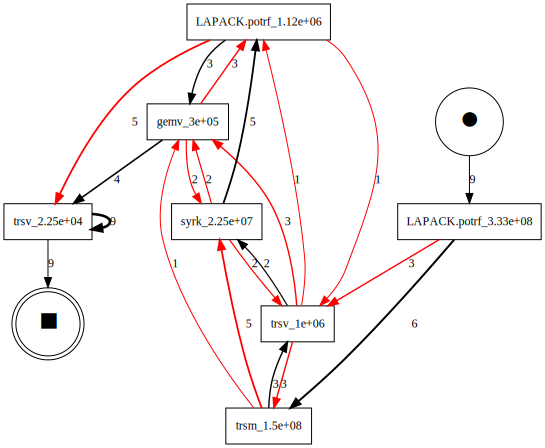

In [144]:
de.data_vcs['1000_150'].get_dfg_minus_best_worst()

In [145]:
de.data_ranks['1000_150']

,case:concept:name,case:rank:q0-q0
0,algorithm5,0
1,algorithm4,1
2,algorithm3,2
3,algorithm0,3
4,algorithm1,4
5,algorithm8,5
6,algorithm7,6
7,algorithm6,7
8,algorithm2,8


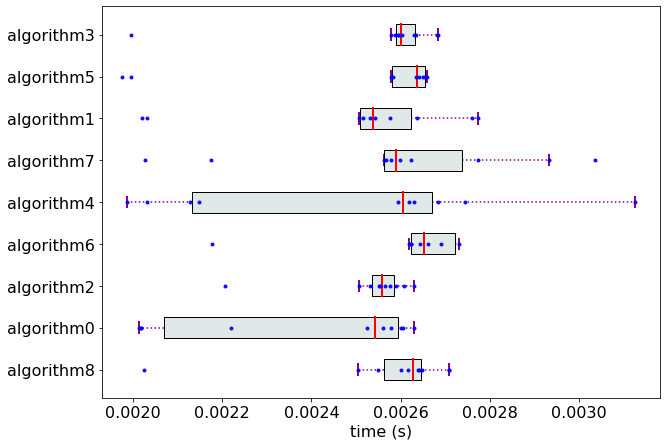

In [146]:
fig = de.visualize_box_plots('1000_150')